In [1]:
import numpy as np
import scipy.stats
from ada_hub.utils import generate_data, find_parameters
from ada_hub.huber_regressor import HuberRegressor, AdaptativeHuberRegressor, TruncatedHuberRegressor, TruncatedAdaptativeHuberRegressor
from sklearn.linear_model import LinearRegression,LassoCV
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
x=np.array([0,2,-2,0.5,-0.5])
lamb = 0.6
np.maximum(np.abs(x) - lamb, np.zeros(x.shape))

array([0. , 1.4, 1.4, 0. , 0. ])

In [2]:
noises = [
    (scipy.stats.norm(0, 4), "normal"),
    (scipy.stats.t(df=1.5), "t-distrib"),
    (scipy.stats.lognorm(s=4, scale=np.exp(0)), "log-norm"),
]

In [10]:
noises[0][0]

80.18735692529513 1.1078292762166646 7.561578945649083


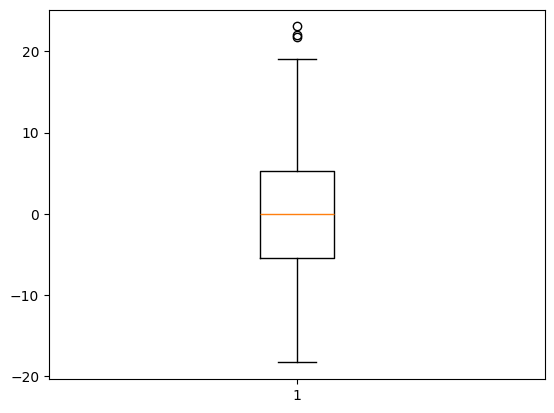

In [3]:
np.random.seed(36)
n, d = 500, 1000
x, y, beta_opt = generate_data(noises[0][0], n, d)
beta_opt = np.concatenate([[0], beta_opt])
tau, lambda_reg = find_parameters(x, y, 0.5, 0.5)
y_hat = np.mean(y)
sigma_hat = np.sqrt(np.mean((y - y_hat)**2))
print(tau, lambda_reg, sigma_hat)

plt.boxplot(y)
plt.show()
plt.close()

In [93]:
#np.random.seed(36)
huber_regressor = HuberRegressor(tau=tau, lambda_reg=lambda_reg)
adhuber_regressor = AdaptativeHuberRegressor(c_tau=.5, c_lambda=.5)
#lin_reg = LinearRegression(fit_intercept=True)
lasso_regessor = LassoCV(cv=3)
lasso_regessor.fit(x, y)
huber_regressor.fit(x, y, beta_0 = (np.random.random(d+1) - .5) * sigma_hat)
adhuber_regressor.fit(x, y)
#lin_reg.fit(x, y)

print(huber_regressor.coef_[0:6])
print(lasso_regessor.coef_[0:6])
print(adhuber_regressor.coef_[0:6])

[ 3.98066832 -1.15090983 -0.         -0.          2.09506457 -0.        ]
[ 4.55401279 -1.75622537 -0.         -0.          2.63002585 -0.        ]
[ 3.42605403  1.29846006 -2.84510278 -1.402891   -2.27663756 -2.29918657]


In [63]:
lasso_regessor.coef_[0:6]

array([ 4.08668461, -1.26154336, -0.        , -0.        ,  2.19259211,
       -0.        ])

In [69]:
huber_regressor.coef_[0:6]

array([ 2.89208123, -0.01602898, -0.        , -0.        ,  1.08585921,
       -0.        ])

In [4]:
regressor = AdaptativeHuberRegressor(c_tau=.5, c_lambda=.5, zero_init=False, fit_intercept=True)
lin_reg = LinearRegression(fit_intercept=True)
l2_error = list()
linear_l2_error = list()
taus = list()
lambdas = list()
for i in tqdm(range(30, len(y))):
    new_x, new_y = x[:i], y[:i]
    regressor.fit(new_x, new_y)
    lin_reg.fit(new_x, new_y)
    l2_error.append(np.sum((beta_opt - np.concatenate([[regressor.intercept_], regressor.coef_]))**2))
    linear_l2_error.append(np.sum((beta_opt - np.concatenate([[lin_reg.intercept_], lin_reg.coef_]))**2))
    taus.append(regressor.tau)
    lambdas.append(regressor.lambda_reg)

100%|██████████| 470/470 [03:06<00:00,  2.52it/s]


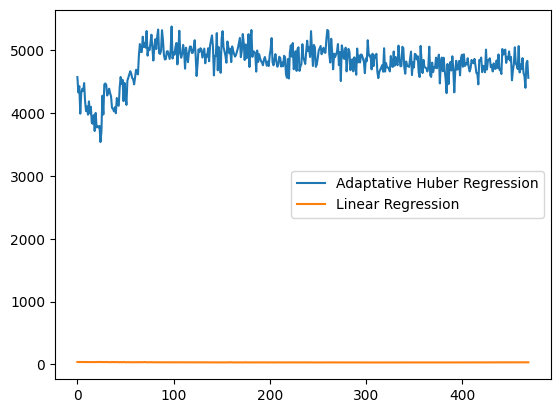

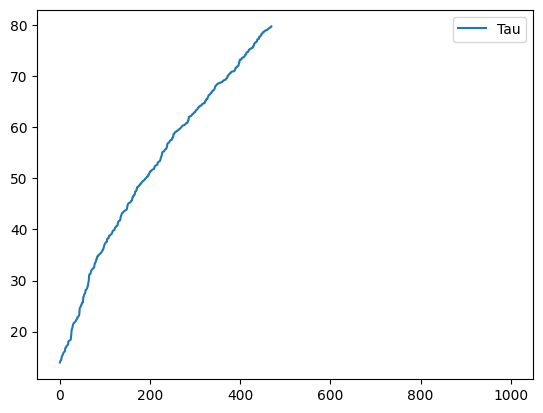

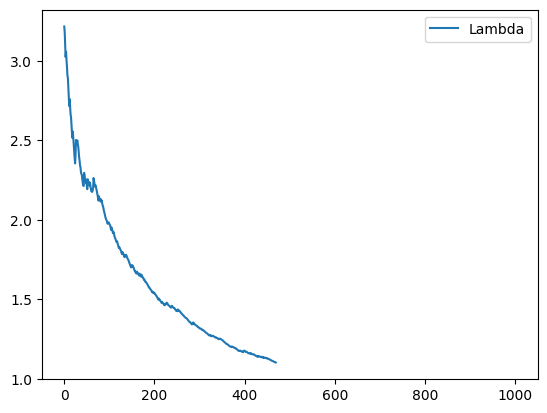

In [5]:
plt.plot(l2_error, label="Adaptative Huber Regression")
plt.plot(linear_l2_error, label="Linear Regression")
plt.legend()
plt.show()
plt.close()
plt.plot(taus, label="Tau")
plt.vlines(d, np.min(taus), np.min(taus))
plt.legend()
plt.show()
plt.close()
plt.plot(lambdas, label="Lambda")
plt.vlines(d, np.min(lambdas), np.min(lambdas))
plt.legend()
plt.show()
plt.close()

# Critique

- On ne fit plus $\tau$ et $\lambda$ mais on a toujours les hyper-paramètres $c_{\lambda}$ et $c_{\tau}$ à tuner.
- On ne retombe pas sur les résultats présentés dans le papier
- La variance du bruit n'est pas toujours finie, l'estimate proposé dans le papier n'est donc pas forcément très adapté

In [7]:
samples = noises[2][0].rvs(500)

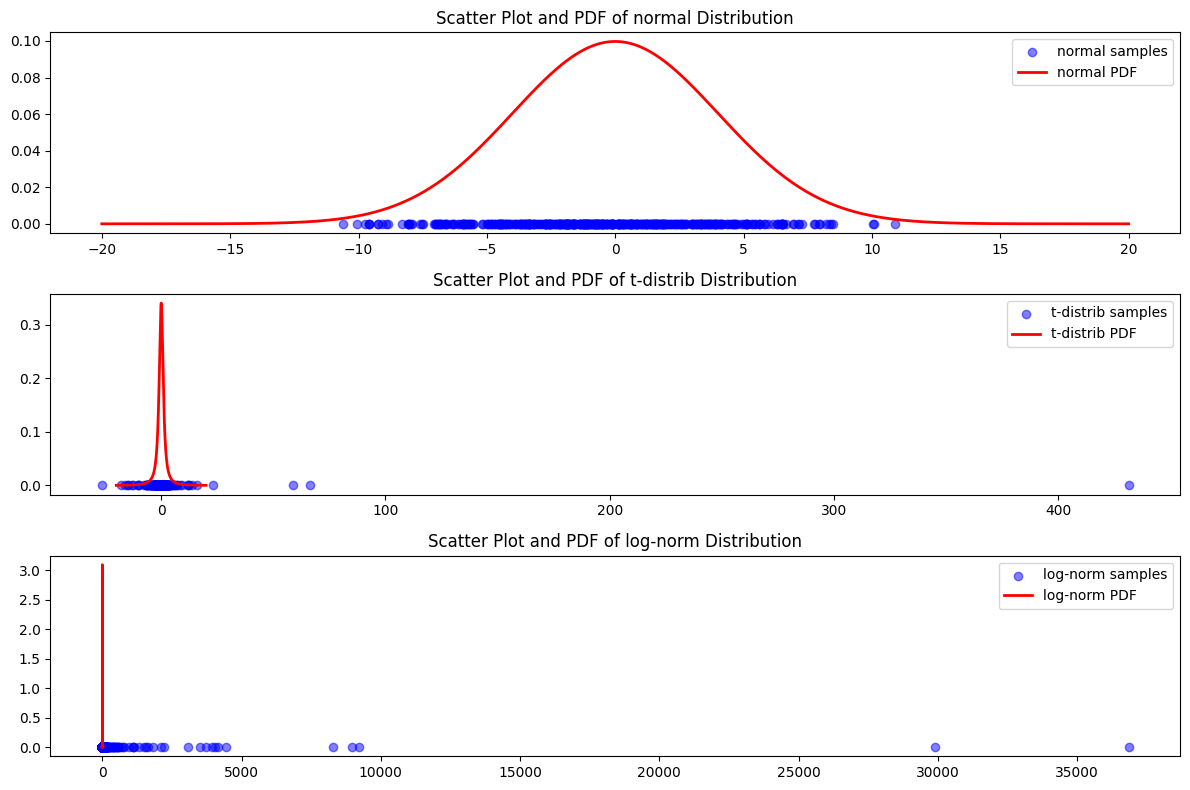

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns

# 定义不同的噪声分布
noises = [
    (scipy.stats.norm(0, 4), "normal"),
    (scipy.stats.t(df=1.5), "t-distrib"),
    (scipy.stats.lognorm(s=4, scale=np.exp(0)), "log-norm"),
]

# 生成x轴的值范围
x_values = np.linspace(-20, 20, 1000)

# 设置样本数量
n_samples = 500

# 创建绘图
plt.figure(figsize=(12, 8))

# 对每种分布绘制
for i, (dist, label) in enumerate(noises, 1):
    # 生成样本
    samples = dist.rvs(n_samples)
    
    # 创建子图
    plt.subplot(3, 1, i)
    
    # 绘制样本的散点图
    plt.scatter(samples, np.zeros_like(samples), alpha=0.5, label=f"{label} samples", color='blue')
    
    # 计算PDF值
    pdf_values = dist.pdf(x_values)
    
    # 绘制PDF曲线
    plt.plot(x_values, pdf_values, label=f"{label} PDF", color='red', lw=2)
    
    # 添加图例和标题
    plt.title(f"Scatter Plot and PDF of {label} Distribution")
    plt.legend()

# 调整图形布局
plt.tight_layout()

# 显示图形
plt.show()

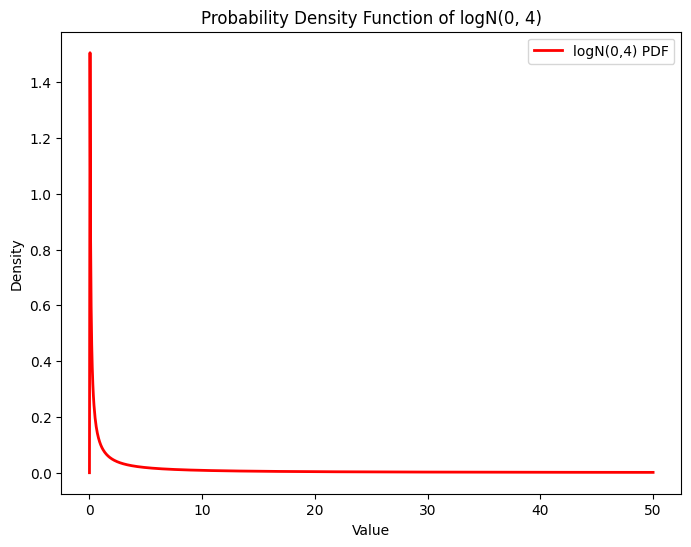

In [11]:
# 定义对数正态分布的参数
mu = 0
sigma = 4
lognorm_dist = scipy.stats.lognorm(s=sigma, scale=np.exp(mu))

# 生成x轴的值范围
x_values = np.linspace(0, 50, 1000)  # 对数正态分布的x值应大于0

# 计算PDF值
pdf_values = lognorm_dist.pdf(x_values)

# 绘制对数正态分布的PDF曲线
plt.figure(figsize=(8, 6))
plt.plot(x_values, pdf_values, label="logN(0,4) PDF", color='red', lw=2)

# 添加标题和标签
plt.title("Probability Density Function of logN(0, 4)")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# 显示图形
plt.show()